In [1]:
# import 
from GLEm_Net import GlemNet
import pandas as pd
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch
from  sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Sleep health and lifestyle dataset

This dataset contains 3 categorical and 8 numerical features. The goal is to predict the type of sleep disorder: apnea or insomnia.

In [2]:
# load the dataset
data = pd.read_csv('Datasets/Sleep_health_and_lifestyle_dataset.csv', delimiter=',').dropna().drop(columns='Person ID')
data.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
6,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
16,Female,29,Nurse,6.5,5,40,7,Normal Weight,132/87,80,4000,Sleep Apnea


In the cell below some of the column in the dataset are preprocessed and the names of the categorical column variables are stored in a list.

In [3]:
# data cleaninig
data['Sleep Disorder'] = data.apply(lambda row: 0 if row['Sleep Disorder'] == 'Sleep Apnea' else 1, axis=1)
data['blood Pressure max'] = data.apply(lambda row: int(row['Blood Pressure'].split('/')[0]), axis=1)
data['blood Pressure min'] = data.apply(lambda row: int(row['Blood Pressure'].split('/')[1]), axis=1)
data = data.drop(columns='Blood Pressure')

# store in a list the name of the categorical variables
categorical = []
for col, ty in zip(data.dtypes.index, data.dtypes):
    if ty=='object':
        categorical.append(col)

To create and train a neural network that uses grouped lasso penalty it is required to perform the following steps in this specific order:

- Create **GlemNet** object specifying: 
    - the dataset (pandas dataframe only), 
    - the list of column that have to be considered categoricals, 
    - the column name of the label,
    - the task that has to be perfomrmed (classification or training),
    - the device (cuda or cpu).           
    
- Call **preprocessing** in order to preprocess the data:
    - numerical encoder,
    - categorical encoder (one hot encoder if no embedding layers are used and ordinal encoder otherwise),
    - a list of three floats to specify te dimensions of the split. If the second value is set to 0 no validation is going to be created.
    - random state.
    
- Call **load_splits** to create the batches for the training:
    - batch size,
    - shuffle data (True or False).
    
- Call **create_model** to initialize the neural network:
    - a list of integer numbers containing the number of neurons contained in each layer. If [12,6] is set, then a neural network containing 12 neurons in the first and 6 neurons in the second layer is created. 
    - hidden_activation, 
    - output_activation, 
    - card_reduction: this parameter regulates the size of the embedding layers. If it is set to 0 then no embedding layers are created and the categorical variables needs to be one hot encoded. Otherwise, if card_reduction>0, it is necessary to use the ordinal encoder (as stated above).

In [4]:
# define the task the we want to perform (classification or regression)
task = 'Classification'

# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the glem_net class specifying the list of categorical and numerical columns, 
# and the label name.
# Additionally, also the task and device are specified
glem_class = GlemNet(data, categorical, 'Sleep Disorder', task, device)

# Using this class it is possible to split, the data and apply the necessary preprocessing techniques to 
# the categorical and numerical features.
glem_class.preprocessing(numerical_preprocessing = 'standardize', categorical_preprocessing= 'one_hot_encoder', splits = [0.7, 0.1, 0.2], random_state = 42)

# The preivously created split are tranformed to tensor and loaded for the training.
glem_class.load_splits(30, True)

# Using this function the model having the desired architecure is set. 
glem_class.create_model([16,4], hidden_activation='tanh', output_activation='sigmoid', card_reduction=0)

Now that the model has been initialized it is possible to train it. It is necessary to define the hyperparameters required, the optimizer and scheduler. If the lambda_coeff is set to zero then no grouped lasso penalty will be applied.

Folder 'results' already exists.
Learning_rate: 0.01
Epoch [1/500], Train Loss: 1.7427, Val Loss: 1.7269

Learning_rate: 0.01
Epoch [101/500], Train Loss: 1.3598, Val Loss: 1.3285

Learning_rate: 0.01
Epoch [201/500], Train Loss: 1.0240, Val Loss: 0.9722

Learning_rate: 0.01
Epoch [301/500], Train Loss: 0.7807, Val Loss: 0.6958

Learning_rate: 0.005
Epoch [401/500], Train Loss: 0.6001, Val Loss: 0.5248



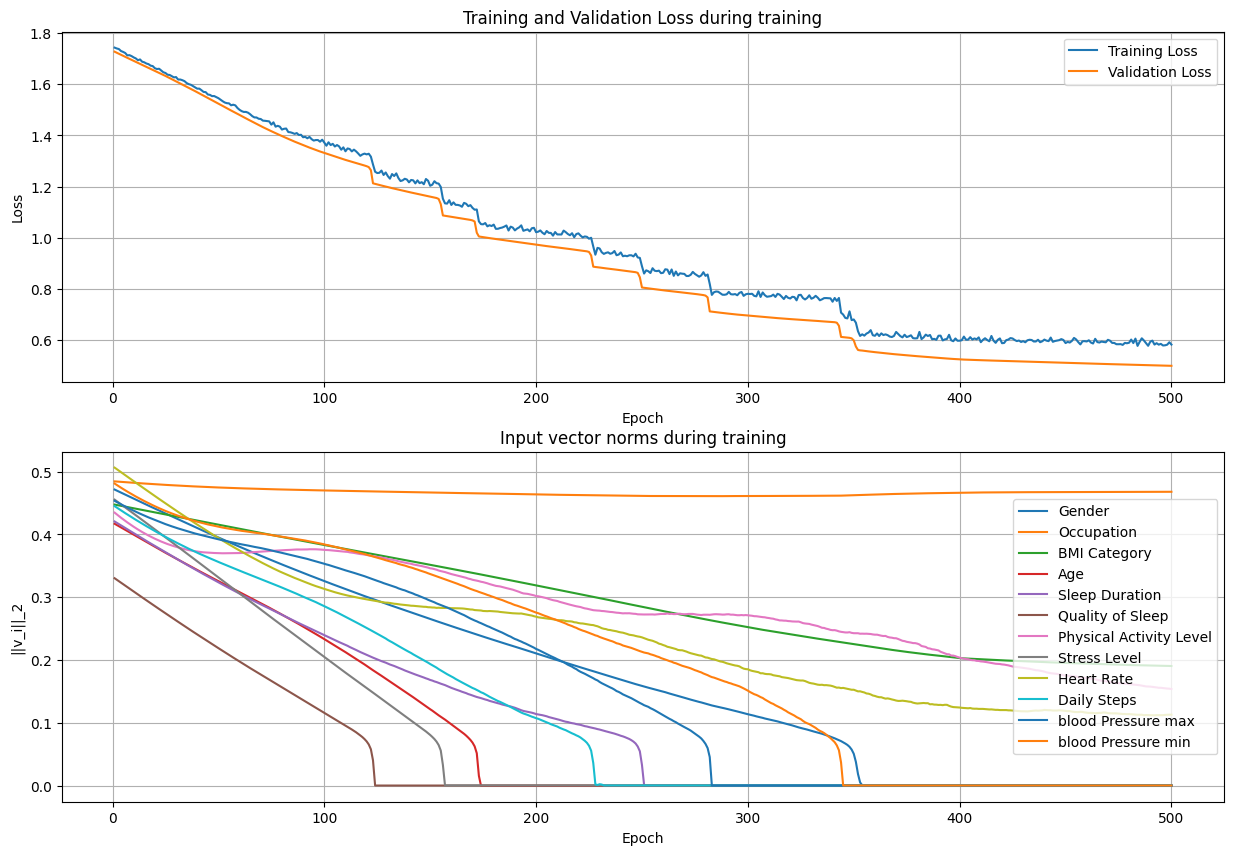

In [5]:
# Hyper-params required for the training
lambda_coeff = 0.06
function_dict = {'name':'exp', 'beta':1e-3, 'gamma':1}
glem_class.set_loss(lambda_coeff, function_dict)
folder_name = 'results'
learning_rate = 0.01
epochs = 500
verbose = 100
freeze = True
eps = 1e-3

                
# The optimizer and the scheduler have to be set outside of the class
optimizer = optim.SGD(glem_class.model.parameters(), lr=learning_rate, momentum=0, nesterov=False)
scheduler = StepLR(optimizer, step_size=400, gamma=0.5)

# The model is trained and the results are stored in the folder specified by the user
glem_class.train_model(epochs, folder_name, optimizer, scheduler, verbose, freeze, eps)

Since the verbose parameter is greater than zero, then the two figures showing the evolution of the losses and norms during training are shown.         

The training function also stores the results in the directory specified by the user.
The stored files are:
- the .pt file containing the best model,
- a .csv file containing the feature norm for each feature during training,
- the image of norms and losses evolution shown above,
- a .csv file which stored the loss of the training and validation for each epoch.

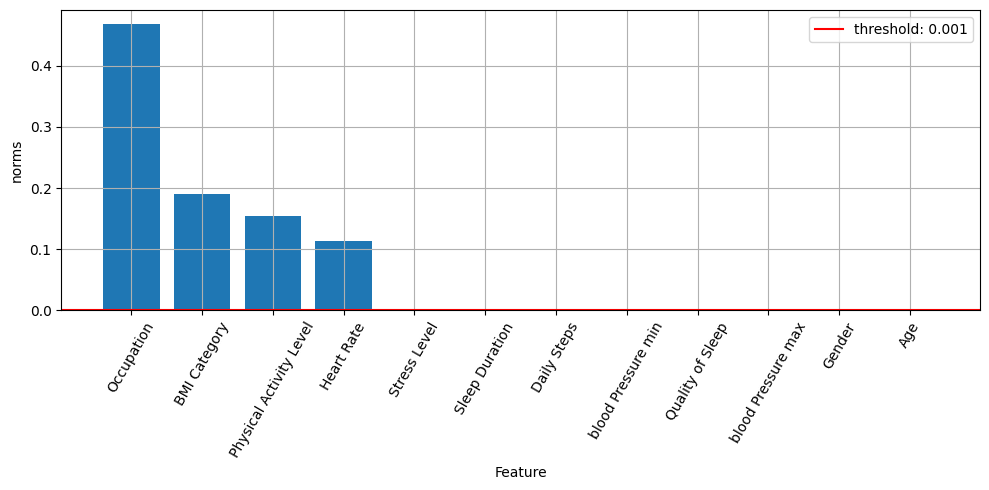

In [6]:
# This function can show the values of the feature norms at the end of the training
glem_class.plot_features_usage()

This other graph shows the values of the features norm at the end of the training and the respective selected threshold. In this case we can see that the model is using only 4 features: 2 categorical nad 3 numerical.      

Now that we identified the subset of most informative features, the weights of the connections between the eliminated features and the first hidden layer have to be set to zero. In this way we are sure that these features will not contribute in making predicitons.

In [7]:
# feature norms before pruning
glem_class.model.compute_norms()[0]

[0.0005720982444472611,
 0.4679023265838623,
 0.19073516130447388,
 0.00027554022381082177,
 0.0008607554482296109,
 0.0007285860483534634,
 0.15358275175094604,
 0.0009538953308947384,
 0.11361363530158997,
 0.0008398147765547037,
 0.0006713885813951492,
 0.0007926625548861921]

In [8]:
# pruning function
glem_class.prune()

In [9]:
# feature norms after pruning
glem_class.model.compute_norms()[0]

[0.0,
 0.4679023265838623,
 0.19073516130447388,
 0.0,
 0.0,
 0.0,
 0.15358275175094604,
 0.0,
 0.11361363530158997,
 0.0,
 0.0,
 0.0]

Now that the weights connecting the features to the first hidden layer have been zeroed, it is possible to predict the label of the samples in the test-set.

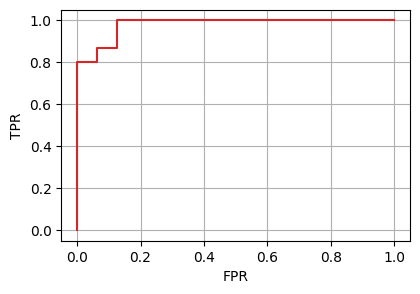

In [10]:
preds = glem_class.predict()
true = glem_class.y_test
fpr, tpr, thresholds = metrics.roc_curve(true, preds)
fig, ax = plt.subplots()
fig.set_size_inches(4.5,3)

ax.plot(fpr, tpr, color='tab:red')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid()
plt.show()

In [11]:
preds = np.where(preds<0.5, 0, 1)

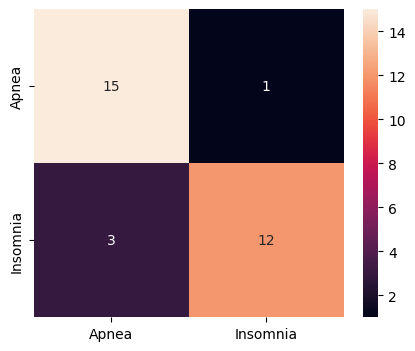

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(5,4)
ax = sns.heatmap(confusion_matrix(true, preds), annot=True)
ax.set_xticklabels(['Apnea','Insomnia'])
ax.set_yticklabels(['Apnea','Insomnia'])

plt.show()